In [1]:
# Jade Chongsathapornpong, August 2023
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, KMeans

from larch import Group
from larch.io import read_ascii, h5group # to read averaged files from PyMCA
from larch.io.specfile_reader import DataSourceSpecH5 # to read files directly from BM23 HDF5
from larch.xafs import sort_xafs, pre_edge, autobk

# Time evolution in PCA representation
This is the same workflow as `xas-compare-pca` but modified to handle plotting "paths" through the PC space.

In [11]:
# 0: calculate principal components on full length spectra, and zero-pad XANES to match in length (doesn't really work)
# 1: truncate all spectra down to the XANES length before calculating principal components (kind of works)
MODE = 1

### Zn K-edge ###
root = r'../Data/BM23_Averaging_PyMCA/Zn_Kedge_Old'
# These are all the end points
names_all = ('HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
         'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C',
         'W32_HEO-Co_RT', 'W36_Zn_RTInit', 'W36_Zn_RTFinal', 'W36_Zn_900C',
         'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
         'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
         'W46_ZnMg_RT', 'ZnO_KOCH_RT')

# This is what we want to fit the PCA to
names_for_pca = ('HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
         'W30_HEO-Mg_RTInit',
         'W32_HEO-Co_RT', 'W36_Zn_RTInit',
         'W37_ZnCo_RTInit',
         'W39_HEO_RTInit',
         'W46_ZnMg_RT', 'ZnO_KOCH_RT')

# These are where to find the HDF5 files, their names, and the relevant scan numbers (see logbook_final.xlsx for info) 
# e.g. (21, 145, 1) will go through all scans from 21 to 144, and (147, 185, 2) will go 147, 149, 151, ...
xanes_info_dict = {'W29_HEO-Ni': ['../Data/BM23/WAM29B/WAM29B_TT/WAM29B_TT.h5', (21, 145, 1), (205, 236, 1)],
         'W30_HEO-Mg': ['../Data/BM23/WAM30C/WAM30C_TT/WAM30C_TT.h5', (21, 146, 1), (206, 237, 1)],
         'W36_Zn'    : ['../Data/BM23/WAM36/WAM36_TT/WAM36_TT.h5', (16, 149, 1), (165, 196, 1)],
         'W37_ZnCo'  : ['../Data/BM23/WAM37C/WAM37C_TT_0002/WAM37C_TT_0002.h5', (1, 102, 1), (118, 149, 1)],
         'W39_HEO'   : ['../Data/BM23/WAM39C/WAM39C_TT/WAM39C_TT.h5', (21, 146, 1), (206, 237, 1)]}

## Loading and interpolating data

In [12]:
def interpolate_xas(in_energies, in_signals, targets=None):
    """Args:
        - in_energies (list or iterable of 1D array) energies or wavenumbers, or single 1D array
        - in_signals (list of 1D array)
        - target_energies (1D array) if None, uses the SHORTEST array in in_energies, 
            and interpolates the remaining in_signal arrays to match it.
    Returns:
        - targets (1D array) a single array of energies (or wavenumbers) interpolated to
        - out_signals (list of 1D array) all the interpolated signals
    """
    if targets is None:
        spectrum_lengths = [len(E) for E in in_energies]
        print("Lengths of spectra:", spectrum_lengths)
        shortest_idx = np.argmin(spectrum_lengths)
        print(f"Mapping to {len(in_energies[shortest_idx])} points from spectra up to {np.max(spectrum_lengths)} long")
        targets = in_energies[shortest_idx]
        
    if isinstance(in_energies, list):
        out_signals = [np.interp(targets, energy, signal) for energy, signal in zip(in_energies, in_signals)]
    else:
        out_signals = [np.interp(targets, in_energies, signal) for signal in in_signals]
        
    return targets, out_signals

def _larchgroup_init(g, name):
    g.is_frozen = False
    g.datatype = 'xas'
    g.xdat = 1000.*g.data[0,:]
    g.ydat = g.data[1,:]/1.
    g.yerr = 1.
    g.energy = g.xdat
    g.mu = g.ydat
    sort_xafs(g, overwrite=True, fix_repeats=True)
    g.groupname = name
    g.energy_orig = g.energy[:]
    g.energy_shift = 0. # this could be taken as an argument later?
    g.energy = g.xdat = g.energy_orig + g.energy_shift
    pre_edge(g) # use defaults for pre and post-edge normalization
    g.norm_poly = 1.0 * g.norm
    autobk(g) # use defaults for auto-background-subtraction
    return g
    
def larch_load_group(path, name, labels='energy_cenc, mu_fluo'):
    """Args:
        - path to csv file with labels, e.g. energy_cenc and mu_fluo (can be changed)
        - name to associate with the group
        - labels of columns to read
    Returns:
        - a Larch Group object with attributes initialized as done in xas_viewer
            according to the Larch buffer"""
    g = read_ascii(path, labels=labels)
    return _larchgroup_init(g, name)

def load_from_dictionary(info_dict, mode, labels=('energy_cenc', 'mu_fluo'), kweight=2):
    """Args:
        - info dict: dictionary with information formatted as in above cell, names_xanes
        - mode: 'chik' or 'mu'
        - labels of columns to read (note it's formatted differently from the way Larch read_ascii takes)
    Returns:
        - a dictionary {name: [[scan ID, k array, chi(k) array], ... ] } if mode 'chik', or energy/mu if 'mu'"""
    ret = {name : [] for name in info_dict}
    for name, info in info_dict.items():
        print("Loading spectra from", name)
        f = DataSourceSpecH5(info[0])
        for start, end, step in info[1:]:
            for scanid in range(start, end, step):
                f.set_scan(scanid)
                energy = f.get_array('energy_cenc')[1:-1]
                mu = f.get_array('mu_fluo')[1:-1]
                group = Group(name=f'{name}_{scanid}', path=info[0])
                group.data = np.vstack((energy, mu))
                _larchgroup_init(group, f'{name}_{scanid}')
                if mode == 'chik':
                    ret[name].append([scanid, group.k, group.chi])
                elif mode == 'mu':
                    ret[name].append([scanid, group.energy, group.mu])
                else:
                    raise ValueError('Invalid mode.')
    return ret
                
def load_from_names(names, mode):
    """Args:
        - names of averaged spectra files (formatted as in the first cell)
        - mode 'chik' or 'mu'
        - kweight (if mode 'chik')
    Returns:
        - ordered list of arrays of wavenumbers (mode chik) or energies (mu) corresponding to:
        - ordered list of arrays of relative absorption weighted by k^kweight (chik) or absorptions (mu)
    Uses interpolate_xas to map all signals down to one signal's wavenumbers
    """
    x = []
    y = []
    for name in names:
        path = join(root, name + '.csv')
        lgrp = larch_load_group(path, name)
        if mode == 'chik':
            kweight = 2
            x.append(lgrp.k)
            y.append(lgrp.chi * np.power(lgrp.k, kweight))
        elif mode == 'mu':
            x.append(lgrp.energy)
            y.append(lgrp.mu)
        else:
            raise ValueError('Invalid mode.')
    return interpolate_xas(x, y)

In [13]:
# Load dataset
# autobk gives inconsistent results on shorter XANES spectra, since it's meant for EXAFS. Suggest mu in this case.
mode = 'mu' # 'mu' 'chik' 
K, CHIK = load_from_names(names_all, mode) # the long spectra
K_pca, CHI_pca = load_from_names(names_for_pca, mode) # PCA expects (n_samples (each signal is a "sample"), n_features (data pts/signal))
xanes_dict = load_from_dictionary(xanes_info_dict, mode) # the near-edge spectra - note this may take a lot of memory

Lengths of spectra: [2096, 2095, 2099, 2086, 2095, 2098, 2086, 2095, 2095, 2099, 2100, 2095, 2100, 2100, 2095, 2094, 2086, 2096, 2095]
Mapping to 2086 points from spectra up to 2100 long
Lengths of spectra: [2096, 2095, 2095, 2095, 2095, 2095, 2095, 2096, 2095]
Mapping to 2095 points from spectra up to 2096 long
Loading spectra from W29_HEO-Ni
Loading spectra from W30_HEO-Mg
Loading spectra from W36_Zn
Loading spectra from W37_ZnCo
Loading spectra from W39_HEO


interpolating XANES to median length 599.0
Mapping all to 599.0 points


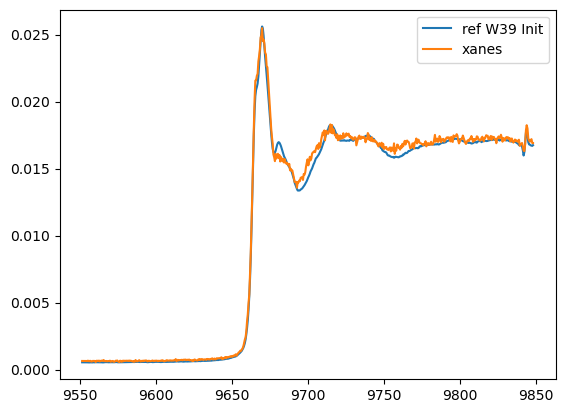

In [15]:
# just a warning that the next few lines are rather disgusting, but they work
# Look at the XANES spectra and get the median length
tolerance = 10
lengths = []
for name, xanes in xanes_dict.items():
    for scan in xanes:
        # each item is [scan ID, k/E, chi(k)/mu(E)]
        lengths.append(len(scan[1]))
l = np.median(lengths) # hopefully this will get a reasonable target
print("interpolating XANES to median length", l)

# Find an exemplar that has the median length, get its k or E
targets = None
for name, xanes in xanes_dict.items():
    if targets is not None:
        break
    for scan in xanes:
        if len(scan[1]) == l:
            targets = scan[1]
            break        

# Interpolate all XANES to median length k or E; set scans
# that are different in length by more than tolerance to be None
for name, xanes in xanes_dict.items():
    for scan in xanes:
        if abs(len(scan[1]) - l) > tolerance:
            scan = None
            continue
        scan[2] = np.interp(targets, scan[1], scan[2])
        scan[1] = targets

if MODE == 0:
    print(f"Mapping XANES to {l} points, to be padded later")
    # Ensure long spectra interpolated to match each other
    _, CHI_pca_interp = K_pca, CHI_pca
    K_interp, CHI_interp = interpolate_xas(K, CHIK, targets=K_pca)
elif MODE == 1:
    # Interpolate/truncate the long spectra to match the XANES spectra
    print(f"Mapping all to {l} points")
    K_interp, CHI_interp = interpolate_xas(K, CHIK, targets=targets)
    _, CHI_pca_interp = interpolate_xas(K_pca, CHI_pca, targets=targets)

# plot a few examples (will need to change these depending on data)
plt.plot(K_interp, CHI_interp[-5], label='ref W39 Init')
plt.plot(xanes_dict['W39_HEO'][100][1], xanes_dict['W39_HEO'][100][2], label='xanes')
plt.legend()
plt.show()

## PCA and Clustering

[9.51581337e-01 2.92851442e-02 1.77002945e-02 6.43119920e-04]


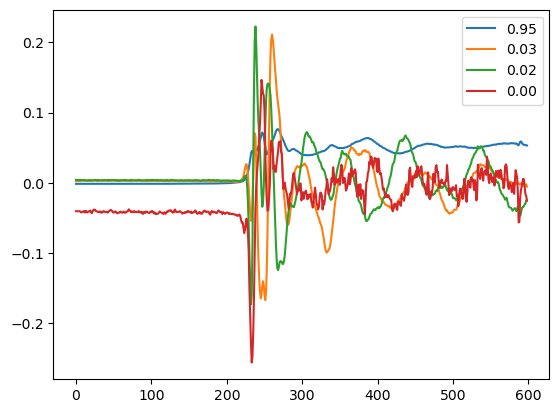

In [16]:
A = np.array(CHI_pca_interp)
pca = PCA(n_components=4) # adjust this number to get appropriate dimensional embeddings.
pca.fit(A)
print(pca.explained_variance_ratio_)
for i in range(4):
    plt.plot(pca.components_[i], label=f"{pca.explained_variance_ratio_[i]:.2f}")
plt.legend()
# plt.savefig("Output/BM23/Zn_mu_PC")
plt.show()

# Save the principal components
# np.savetxt('Output/BM23/principalcomponents_Zn_mu_short.csv', pca.components_.transpose(), delimiter=',')

In [17]:
# apply PCA to reference signals
reduced = pca.transform(np.array(CHI_interp))
print(f"Reference: {reduced.shape[0]} signals embedded in {reduced.shape[1]} dimensions.") 
# Save the PCA embeddings of each reference signal
# embedding_df = pd.DataFrame(reduced)
# embedding_df['sample'] = names_all
# embedding_df.to_csv('Output/BM23/pca_embeddings_Zn_mu_short.csv')

# apply PCA to the XANES time evolving signals, either with zero padding (MODE 0) or directly (MODE 1)
evolutions = {name : [] for name in xanes_dict} # list will contain (scanid, PCA embedding)
for name, xanes in xanes_dict.items():
    for scanid, x, y in xanes:
        if MODE == 0:
            # interpolate to match the x-coordinates of PCs
            pca_x = (pca.components_[0])[0:len(x)]
            yf = np.interp(pca_x, x, y)
            # zero pad to match the lengths of PCs
            yf = np.pad(yf, (0, len(pca.components_[0]) - len(x)), 'constant', constant_values=0)
        elif MODE == 1:
            yf = y
        evolutions[name].append((scanid, pca.transform(yf.reshape(1,-1))))

# Perform clustering on the references
ap = AffinityPropagation().fit(reduced)
clusterings = {key: [] for key in np.unique(ap.labels_)}
for i, name in enumerate(names_all):
    clusterings[ap.labels_[i]].append((i, name))
    
print(clusterings)

Reference: 19 signals embedded in 4 dimensions.
{0: [(0, 'HEO-SSR_RT'), (1, 'W29_HEO-Ni_RTInit'), (2, 'W29_HEO-Ni_RTFinal'), (3, 'W29_HEO-Ni_900C'), (14, 'W39_HEO_RTInit'), (15, 'W39_HEO_RTFinal'), (16, 'W39_HEO_900C')], 1: [(4, 'W30_HEO-Mg_RTInit'), (5, 'W30_HEO-Mg_RTFinal'), (6, 'W30_HEO-Mg_900C'), (7, 'W32_HEO-Co_RT'), (8, 'W36_Zn_RTInit'), (9, 'W36_Zn_RTFinal'), (10, 'W36_Zn_900C'), (17, 'W46_ZnMg_RT')], 2: [(11, 'W37_ZnCo_RTInit'), (12, 'W37_ZnCo_RTFinal'), (13, 'W37_ZnCo_900C'), (18, 'ZnO_KOCH_RT')]}


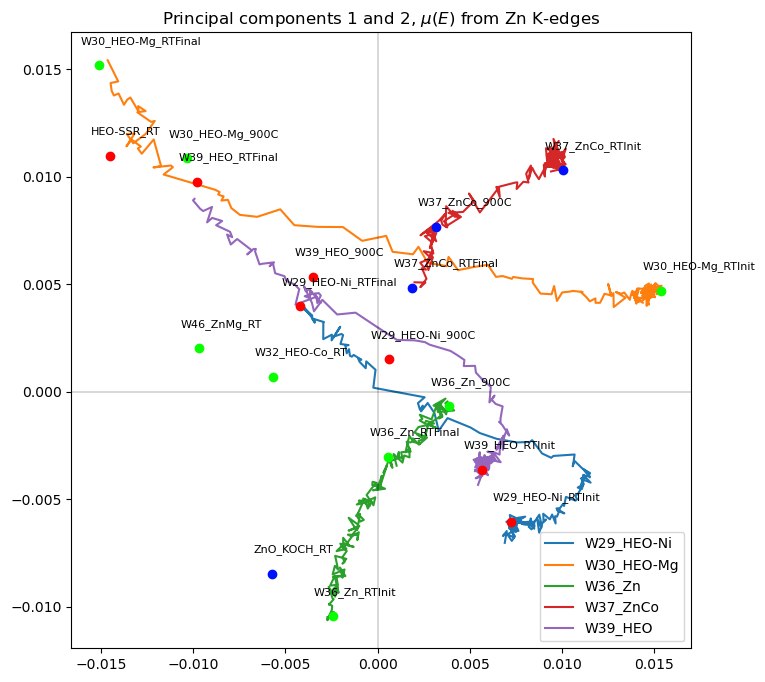

In [18]:
dim0 = 1 # 0, 1, 2, 3, 4, 5; dimensions of the PCA
dim1 = 2

adj_text_idx = ()#(13, 15) # indices into names_all for which to adjust text position

fig, ax = plt.subplots(figsize=(8,8))

# Plot evolutions
for name, embeddings in evolutions.items():
    signalmat = np.array([e[1] for e in embeddings]).squeeze() # note this assumes scanid were sorted
    x = signalmat[:,dim0]
    y = signalmat[:,dim1]
    ax.plot(x, y, label=name)
    
# Plot references
for i, signalvec in enumerate(reduced):
    adj = 0.2 if i in adj_text_idx else 0.
    ax.axhline(0, linewidth=0.01, color='k')
    ax.axvline(0, linewidth=0.01, color='k')
    ax.plot(signalvec[dim0], signalvec[dim1], 'o', c=cm.hsv(ap.labels_[i]/(max(ap.labels_) + 1)))
    ax.text(signalvec[dim0]-0.001-adj, signalvec[dim1]+0.001+adj, names_all[i], fontsize=8)
ax.set_title(f"Principal components {dim0} and {dim1}, $\mu(E)$ from Zn K-edges")

plt.legend(loc='lower right')
# plt.savefig(f"Output/BM23/Zn_PCA/PCA_Zn_mu_short_{dim0}_{dim1}", dpi=300)
plt.show()